<a href="https://colab.research.google.com/github/psophis/CNN-image-classification-modes-of-transportation/blob/main/CNN_image_classification_modes_of_transportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNN to classify images
## Categorising images of modes of transportation

Data source:
https://www.kaggle.com/datasets/imbikramsaha/caltech-101

I will only pick classes that contain images of **modes of transportation**. By picking only a few of the 101 classes, my models won't require as much computational power and time for training.

**The classes my models will work with are:**


*   motorbikes
*   airplanes
*   cars (side profile)
*   ferries
*   helicopters
*   schooners

### Import libraries

In [1]:
!pip install opendatasets

In [16]:
import opendatasets as od
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.preprocessing import label_binarize
import collections

### Import data

In [28]:
od.download("https://www.kaggle.com/datasets/imbikramsaha/caltech-101")

Skipping, found downloaded files in "./caltech-101" (use force=True to force download)


In [4]:
base_path = Path("caltech-101/caltech-101")

categories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d))
])

print("Number of categories:", len(categories))
print("First 10 categories:", categories[:10])

Number of categories: 102
First 10 categories: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel']




---



## Data exploration

I want to get an idea of the way the data is distributed across categories.

In [5]:
all_img = list(base_path.rglob("*.jpg"))
df = pd.DataFrame({
    "image_path": all_img,
    "label": [p.parent.name for p in all_img]
})

exclude_background = 'BACKGROUND_Google'
counts = df['label'].value_counts().sort_values(ascending=False)
counts = counts.drop(exclude_background)

print(df.head())
print(f"\ncount all images: {counts.sum()}")

                                        image_path     label
0  caltech-101/caltech-101/scissors/image_0035.jpg  scissors
1  caltech-101/caltech-101/scissors/image_0010.jpg  scissors
2  caltech-101/caltech-101/scissors/image_0025.jpg  scissors
3  caltech-101/caltech-101/scissors/image_0012.jpg  scissors
4  caltech-101/caltech-101/scissors/image_0026.jpg  scissors

count all images: 8677


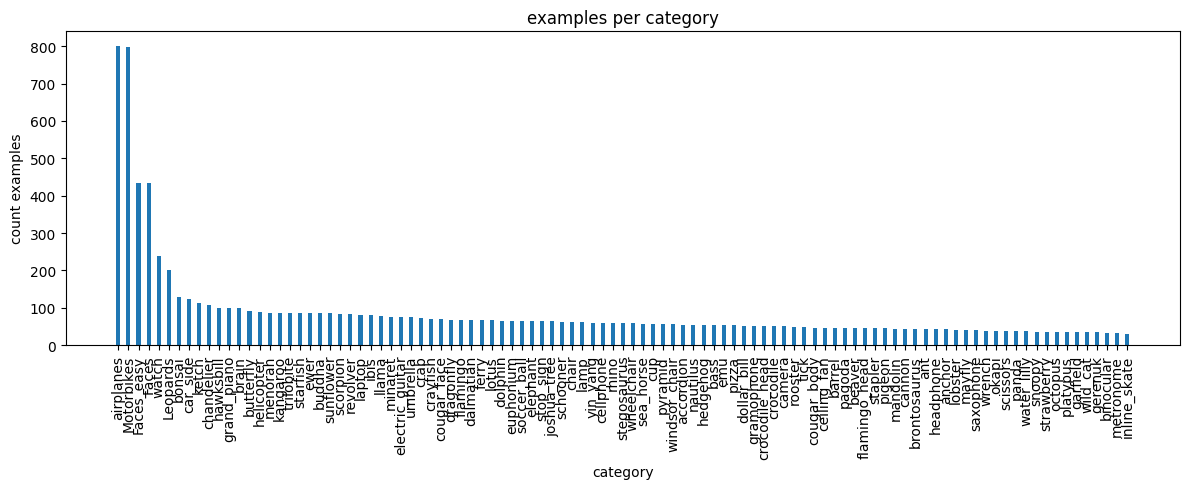

In [6]:
plt.figure(figsize=(12, 5))
plt.bar(counts.index, counts.values, width=0.4)
plt.xticks(rotation=90)
plt.xlabel("category")
plt.ylabel("count examples")
plt.title("examples per category")
plt.tight_layout()
plt.show()

It is clear that the classes are very imbalanced, and I can already see that two of my classes are the ones with the most examples (`airplanes` and `motorbikes`). I will have to check the distribution again for my chosen classes after creating the dataframe I'm going to work with.

**What does the data set contain?**

The dataset contains image data for its 101 categories. The amount of examples per class varies strongly, with most classes containing ~100 images, while some classes provide several hundred.

**What does the data set not contain?**

Depending on the class, there aren't very many examples to train on. The class `inline-skate` for example only has 31 files, and they all show the object in a side view. The same is the case for the `car` category, which will be part of my dataframe. That means that my model will learn images with cars showing the side profile, but won't be able to reliably classify images that show cars from a different perspective.

# Preprocessing

## Creating the dataframe

First, I'm picking my selected categories to create the dataframe.

In [7]:
selected_categories = ["Motorbikes", "airplanes", "car_side", "ferry", "helicopter", "schooner"]
df_filtered = df[df["label"].isin(selected_categories)]

print(df_filtered.head())
print("\nSelected categories for my dataframe:", df_filtered['label'].unique())
print("Count all remaining images:", len(df_filtered))

                                            image_path      label
1274  caltech-101/caltech-101/airplanes/image_0686.jpg  airplanes
1275  caltech-101/caltech-101/airplanes/image_0599.jpg  airplanes
1276  caltech-101/caltech-101/airplanes/image_0392.jpg  airplanes
1277  caltech-101/caltech-101/airplanes/image_0203.jpg  airplanes
1278  caltech-101/caltech-101/airplanes/image_0692.jpg  airplanes

Selected categories for my dataframe: ['airplanes' 'schooner' 'car_side' 'Motorbikes' 'helicopter' 'ferry']
Count all remaining images: 1939


One example per category from my dataframe:

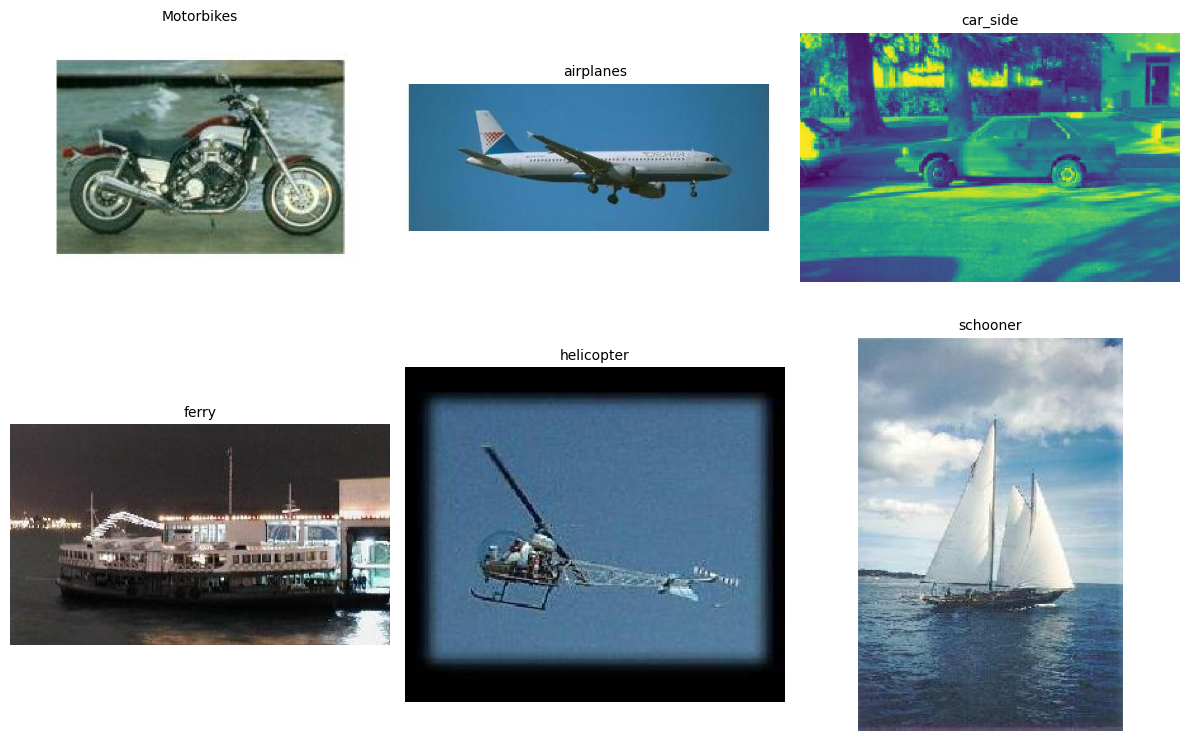

In [8]:
cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for i, label in enumerate(selected_categories):
    img_path = df_filtered.loc[df_filtered["label"] == label, "image_path"].iat[0]
    img = Image.open(img_path)

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

After creating the dataframe, I want to check the distribution of examples per category again to see how strong the imbalance is.

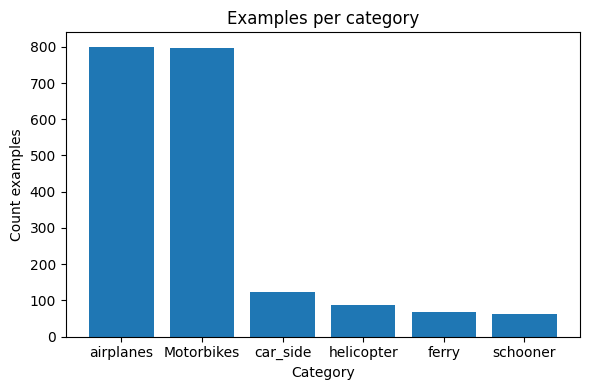

--- Distribution of classes: ---
 label
Motorbikes    41.16
airplanes     41.26
car_side       6.34
ferry          3.46
helicopter     4.54
schooner       3.25
Name: proportion, dtype: float64

--- Examples per class: ---
 label
Motorbikes    798
airplanes     800
car_side      123
ferry          67
helicopter     88
schooner       63
Name: count, dtype: int64


In [9]:
counts = df_filtered['label'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values)
plt.xlabel('Category')
plt.ylabel('Count examples')
plt.title('Examples per category')
plt.tight_layout()
plt.show()

examples = df_filtered['label'].value_counts().sort_index()
distribution = (df_filtered['label'].value_counts(normalize=True) * 100).round(2)
distribution = distribution.sort_index()
print('--- Distribution of classes: ---\n', distribution)
print('\n--- Examples per class: ---\n', examples)

There is a clear imbalance. I will augment classes `car_side`, `ferry`, `helicopter` and `schooner` in my training data at a later step, to make sure that they're not so underrepresented that my model has issues generalizing.

### Sizing the images

I'll find the minimum images sizes to scale all images down, to ensure that they are the same size.

In [10]:
# create a list of all images in df_filtered
images = [Image.open(str(p)) for p in df_filtered["image_path"]]  # open the images

# extract sizes of each image
heights = [i.height for i in images ]
widths = [i.width for i in images ]

# find minima
min_height = min(heights)
min_width = min(widths)

print(f'Minimal height:', min_height)
print(f'Minimal width:', min_width)

Minimal height: 101
Minimal width: 162


Next up, I'm creating a folder for my categories with this structure:

six_classes/

├── airplanes/

├── Motorbikes/

├── car_side/

├── ferry/

├── helicopter/

└── schooner/

In [11]:
# creating a folder with my classes
!mkdir six_classes
!cp -r caltech-101/caltech-101/airplanes six_classes/
!cp -r caltech-101/caltech-101/Motorbikes six_classes/
!cp -r caltech-101/caltech-101/car_side six_classes/
!cp -r caltech-101/caltech-101/ferry six_classes/
!cp -r caltech-101/caltech-101/helicopter six_classes/
!cp -r caltech-101/caltech-101/schooner six_classes/

# create Path object that points to the six_classes folder
data_dir = Path("six_classes")

# load images from the new directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',                  # keep folder names for the labels
    label_mode='int',                   # represent labels numerically
    image_size=(min_height, min_width), # resize
    batch_size=85,                      # load images in batches
    shuffle=True
)

class_names = dataset.class_names
dataset = dataset.unbatch()             # make each unit in the ds a pair of image and label (tf loads img data in batches, for efficiency)

print(f'Class names: {class_names}')

Found 1939 files belonging to 6 classes.
Class names: ['Motorbikes', 'airplanes', 'car_side', 'ferry', 'helicopter', 'schooner']


### Create final datasets for training, validation and testing

In [12]:
# split up the examples
counts = df_filtered['label'].value_counts()
counts = counts.sum()
split = (counts/3)
val_size = int(counts * 0.1)

df_test = dataset.take(split)
df_val = dataset.skip(split).take(val_size)
df_train = dataset.skip(split + val_size)

print(f'Training data: {df_train.reduce(0, lambda x, _: x + 1)}')
print(f'Validation data: {df_val.reduce(0, lambda x, _: x + 1)}')
print(f'Test data: {df_test.reduce(0, lambda x, _: x + 1)}')

# give each train/val/test step a batch of images
ds_train = df_train.batch(32)
ds_val = df_val.batch(32)
ds_test = df_test.batch(32)

Training data: 1100
Validation data: 193
Test data: 646


### Oversampling

In [13]:
# data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.3)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    image = tf.image.random_crop(image, size=[min_height, min_width, 3])
    return image, label

ds_unbatched = ds_train.unbatch()

# classes to be augmented
car_class_index = class_names.index('car_side')
ferry_class_index = class_names.index('ferry')
helicopter_class_index = class_names.index('helicopter')
schooner_class_index = class_names.index('schooner')

# augment 'car_side'
ds_car = ds_unbatched.filter(lambda img, lbl: tf.equal(lbl, tf.cast(car_class_index, lbl.dtype)))
ds_car = ds_car.map(augment).repeat(5)

# augment 'ferry'
ds_ferry = ds_unbatched.filter(lambda img, lbl: tf.equal(lbl, tf.cast(ferry_class_index, lbl.dtype)))
ds_ferry = ds_ferry.map(augment).repeat(11)

# augment 'helicopter'
ds_helicopter = ds_unbatched.filter(lambda img, lbl: tf.equal(lbl, tf.cast(helicopter_class_index, lbl.dtype)))
ds_helicopter = ds_helicopter.map(augment).repeat(8)

# augment 'schooner'
ds_schooner = ds_unbatched.filter(lambda img, lbl: tf.equal(lbl, tf.cast(schooner_class_index, lbl.dtype)))
ds_schooner = ds_schooner.map(augment).repeat(12)

# concatenate
ds_train = ds_unbatched.concatenate(ds_car).concatenate(ds_ferry).concatenate(ds_schooner).concatenate(ds_helicopter)
ds_train = ds_train.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

I have now created augmented duplicates of the underrepresented image data and added them back into my training dataset.

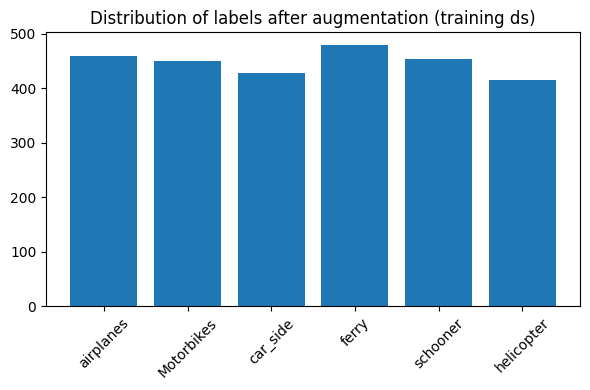

--- Examples per class ---
airplanes   : 459
Motorbikes  : 450
car_side    : 429
ferry       : 479
schooner    : 454
helicopter  : 415


In [17]:
all_labels = []

for _, label_batch in ds_train.unbatch().take(5000):
    all_labels.append(int(label_batch.numpy()))

label_counts = collections.Counter(all_labels)
label_counts_named = {class_names[k]: v for k, v in label_counts.items()}

plt.figure(figsize=(6, 4))
plt.bar(label_counts_named.keys(), label_counts_named.values())
plt.title("Distribution of labels after augmentation (training ds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("--- Examples per class ---")
for label, count in label_counts_named.items():
    print(f"{label:<12}: {count}")

After checking the distribution again, it is clear that the imbalance isn't as harsh as it was before. This will give my model more examples per underrepresented category to learn and will enable it to generalize better after training.



---



# Training

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

## Vanilla CNN model (3 layers)

### Build & train

In [ ]:
# define and compile model
def create_model(min_height, min_width):
  # input-tensor with images that have max height & width and 3 color channels (RGB)
  inputs = tf.keras.Input(shape=(min_height, min_width, 3))

  # normalization: scale pixel color values [0, 255] to [0.0, 1.0] for consistent input data
  x = keras.layers.Rescaling(1./255)(inputs)

  # convolutional layer with 32 filters (size 3x3)
  x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  # pooling layer (size 2x2)
  x = keras.layers.MaxPooling2D((2, 2))(x)

  # more filters to learn more complex feature
  x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = keras.layers.MaxPooling2D((2, 2))(x)

  x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = keras.layers.MaxPooling2D((2, 2))(x)

  # 3D feature map array to flat vector
  x = keras.layers.Flatten()(x)

  # classification
  x = keras.layers.Dense(64, activation='relu')(x)
  outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  # compile
  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # int labels
      metrics=['accuracy']
  )

  return model

In [ ]:
plain_cnn = create_model(min_height, min_width)

# overview
plain_cnn.summary()

# training
history = plain_cnn.fit(
    ds_train,
    epochs=6,
    validation_data=ds_val)

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 101, 162, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 101, 162, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 101, 162, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 50, 81, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 50, 81, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 25, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 25, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     1,966,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,059,782 (7.86 MB)

 Trainable params: 2,059,782 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
     85/Unknown 138s 2s/step - accuracy: 0.5553 - loss: 1.4267

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5565 - loss: 1.4224 - val_accuracy: 0.7617 - val_loss: 0.5944
Epoch 2/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8844 - loss: 0.3562 - val_accuracy: 0.9430 - val_loss: 0.1466
Epoch 3/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9418 - loss: 0.1845 - val_accuracy: 0.9067 - val_loss: 0.3102
Epoch 4/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9578 - loss: 0.1289 - val_accuracy: 0.9793 - val_loss: 0.0423
Epoch 5/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9674 - loss: 0.1003 - val_accuracy: 0.9637 - val_loss: 0.0850
Epoch 6/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9817 - loss: 0.0567 - val_accuracy: 0.9948 - val_loss: 0.0114


In [ ]:
# save model
plain_cnn.save('simple_cnn.keras')

### Visualization of Conv2D layer filters and saliency map

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

**Prepare saliency map:**

In [ ]:
!pip install tf-keras-vis tensorflow

In [ ]:
# fetch image
model_height, model_width = plain_cnn.input_shape[1:3]
for images, labels in ds_val.take(1):
    raw_image = images[0].numpy()
    input_label = labels[0].numpy()                        # shape (1, h, w, 3)
    break

# prep image for model
input_image = tf.image.resize(raw_image, (model_height, model_width))
input_image = tf.cast(input_image, dtype=tf.float32)
input_image_batch = np.expand_dims(input_image, axis=0)     # shape (1, h, w, 3)

# replace softmax with linear function
replace2linear = ReplaceToLinear()

# define score class
score = CategoricalScore([input_label])

# create saliency object
saliency = Saliency(plain_cnn, model_modifier=replace2linear, clone=True)

# generate saliency map
saliency_map = saliency(score, input_image_batch)           # shape (1, h, w, 3)

# prepare saliency map
saliency_map = saliency_map[0]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_935
Received: inputs=['Tensor(shape=(1, 101, 162, 3))']
  warnings.warn(msg)


The saliency map is very noisy, so instead I'll be using GradCam++.

In [ ]:
# create GradCam++ object
gradcam = GradcamPlusPlus(plain_cnn, model_modifier=replace2linear, clone=True)

# generate saliency map
cam = gradcam(score, input_image_batch)           # shape (1, h, w, 3)

# prepare saliency map
gradcam_map = cam[0]

*Source for Saliency Map and GradCAM++ code: [https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html](https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html)*

**Prepare filter visualisation:**

In [ ]:
def print_avg_rgb_filters(filters, n=6):
    for i in range(n):
        f = filters[:, :, :, i]
        f_avg = np.mean(f, axis=2)
        print(f"\nFilter {i+1}:")
        print(np.round(f_avg, 3))

def print_filters(filters, n=6, channel=0):
    for i in range(n):
        f = filters[:, :, channel, i]
        print(f"\nFilter {i+1}:")
        print(np.round(f, 3))

# get Conv2D layers
conv_layer_1 = plain_cnn.layers[2]
filters1, biases1 = conv_layer_1.get_weights()
conv_layer_2 = plain_cnn.layers[4]
filters2, biases2 = conv_layer_2.get_weights()

# take pic
for images, labels in ds_train.take(1):
  input_image = images[0:1]
  break

# get outputs of layers
layer1_outputs = [plain_cnn.layers[2].output]
activation_model_1 = tf.keras.models.Model(inputs=plain_cnn.input, outputs=layer1_outputs)
layer2_outputs = [plain_cnn.layers[4].output]
activation_model_2 = tf.keras.models.Model(inputs=plain_cnn.input, outputs=layer2_outputs)

# calculate feature maps
feature_maps_1 = activation_model_1.predict(input_image)
feature_maps_2 = activation_model_2.predict(input_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


**Visualize filters and saliency map:**

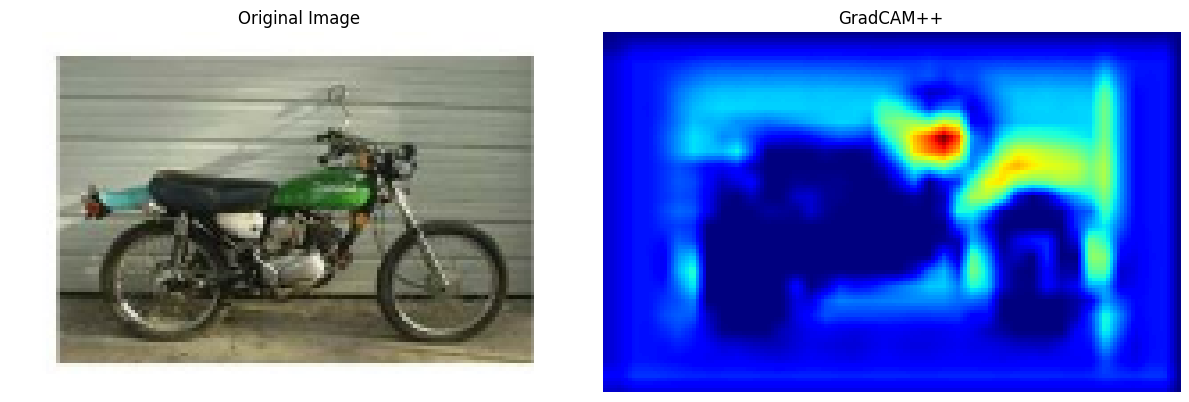


Conv2D layer 1 filters:


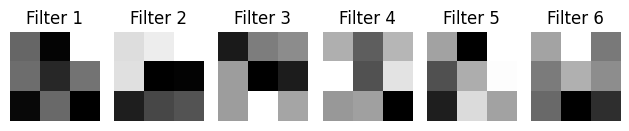


Filter 1:
[[ 0.012 -0.055  0.118]
 [ 0.017 -0.032  0.021]
 [-0.053  0.014 -0.059]]

Filter 2:
[[ 0.045  0.053  0.064]
 [ 0.046 -0.077 -0.075]
 [-0.06  -0.037 -0.031]]

Filter 3:
[[-0.066  0.004  0.015]
 [ 0.027 -0.084 -0.064]
 [ 0.027  0.096  0.032]]

Filter 4:
[[ 0.011 -0.035  0.015]
 [ 0.057 -0.043  0.04 ]
 [-0.003  0.002 -0.09 ]]

Filter 5:
[[ 0.008 -0.104  0.072]
 [-0.049  0.015  0.07 ]
 [-0.083  0.047  0.007]]

Filter 6:
[[ 0.022  0.077 -0.004]
 [-0.002  0.029  0.008]
 [-0.013 -0.076 -0.048]]


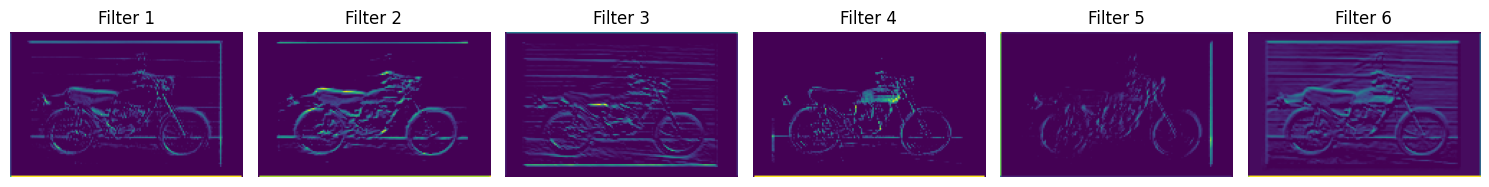


Conv2D layer 2 filters:


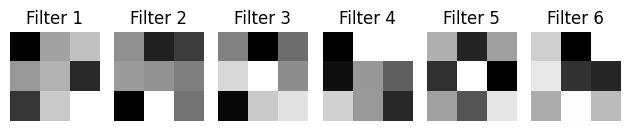


Filter 1:
[[-0.091 -0.008  0.008]
 [-0.013  0.    -0.07 ]
 [-0.063  0.012  0.04 ]]

Filter 2:
[[-0.035 -0.072 -0.063]
 [-0.032 -0.035 -0.041]
 [-0.082  0.001 -0.045]]

Filter 3:
[[-0.011 -0.095 -0.023]
 [ 0.046  0.072 -0.003]
 [-0.089  0.037  0.053]]

Filter 4:
[[-0.047  0.12   0.121]
 [-0.037  0.052  0.015]
 [ 0.09   0.053 -0.021]]

Filter 5:
[[ 0.027 -0.039  0.02 ]
 [-0.034  0.065 -0.057]
 [ 0.02  -0.016  0.052]]

Filter 6:
[[ 0.032 -0.106  0.065]
 [ 0.049 -0.072 -0.08 ]
 [ 0.009  0.063  0.019]]


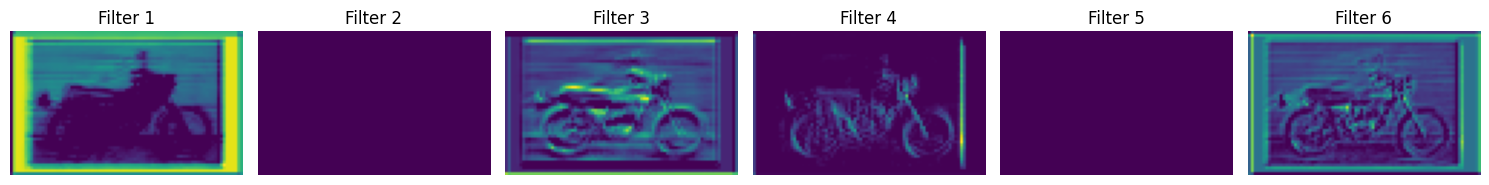

In [ ]:
# show original image with saliency map
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image[0] / 255.0)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('GradCAM++')
plt.imshow(gradcam_map, cmap='jet')
plt.axis('off')
plt.tight_layout()
plt.show()

# show first six filters of layer 1
n_filters = 6
for i in range(n_filters):
  f = filters1[:, :, :, i]                    # (3, 3, 32)
  f_gray = np.mean(f, axis=2)                 # (3, 3)
  plt.subplot(1, n_filters, i+1)
  plt.imshow(f_gray, cmap='gray')
  plt.axis('off')
  plt.title(f'Filter {i+1}')
print(f'\nConv2D layer 1 filters:')
plt.tight_layout()
plt.show()

# numeric display of filters
print_avg_rgb_filters(filters1, n=n_filters)

# visualize
num_maps = 6
plt.figure(figsize=(15, 4))
for i in range(num_maps):
  plt.subplot(1, num_maps, i+1)
  plt.imshow(feature_maps_1[0, :, :, i])
  plt.axis('off')
  plt.title(f'Filter {i+1}')
plt.tight_layout()
plt.show()

# show filters of layer 2
for i in range(n_filters):
  f = filters2[:, :, 0, i]                    # (3, 3, 32)
  plt.subplot(1, n_filters, i+1)
  plt.imshow(f, cmap='gray')
  plt.axis('off')
  plt.title(f'Filter {i+1}')
print(f'\nConv2D layer 2 filters:')
plt.tight_layout()
plt.show()

# numeric display of filters
print_filters(filters2, n=n_filters)

# visualize
num_maps = 6
plt.figure(figsize=(15, 4))
for i in range(num_maps):
  plt.subplot(1, num_maps, i+1)
  plt.imshow(feature_maps_2[0, :, :, i])
  plt.axis('off')
  plt.title(f'Filter {i+1}')
plt.tight_layout()
plt.show()

**What kind of features did the filters extract?**

Layer 1:

*   Filter 1: detects bright spots in the upper right corner of a structure
*   Filter 2: higher values in the top row; might detect structures that are bright at the top and darker below
*   Filter 3: slanted edges `\`
*   Filter 4:  vertical edges
*   Filter 5: diagonals `/`
*   Filter 6: slightly slanted horizontal edges `\`, but activates bright areas more than filter 3

Layer 2:

*   Filter 1: reacts to increase in brightness from top left (small values) to lower right corner (higher values) --> bigger, even areas?
*   Filter 2: values are rather close to one another; might detect less texturized structures
*   Filter 3: horizontal, potentially slanted structures where the upper section is darker than the lower section
*   Filter 4: reacts more strongly on the right than the left; reacts in areas with vertical edges that go from dark (left) to bright (right)
*   Filter 5: react to small areas with high contrast
*   Filter 6: values are further apart, stronger contrasts here with a small dark diagonal; might react to areas where the left and right are brighter than the middle part


**Are there "blind" filters that didn't learn anything? Why? How could I fix that?**

There are multiple filters that don't get activated, the amount of inactive filters and which filter(s) stay inactive depends on the input image. That's why I don't think that I should change them. Even if a filter doesn't react to image A, it will react to image B. If I wanted to have more filters activated, I could train for more epochs or maybe adjust the learning rate.


**Does the model consider the background of the inputs?**

Yes, it does partially, for example for flying objects like planes and helicopters. However, both classes contain examples where the planes and helicopters don't just have the blue sky as a background.


**Does the model consider the color of the inputs?**

The first layer takes each of the RGB channels as input, and outputs a feature maps. From that point on, the color channels can't be separated anymore.

### Evaluation

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

mean_train_acc = np.mean(train_acc)
mean_val_acc = np.mean(val_acc)

print(f"Ø train accuracy: {mean_train_acc*100:.2f} %")
print(f"Ø validation accuracy: {mean_val_acc*100:.2f} %")

Ø train accuracy: 85.17 %
Ø validation accuracy: 92.75 %


#### Classification report

In [ ]:
# initialize containers
true_labels = []        # actual labels
predicted_labels = []
predicted_proba = []    # highest predicted probability of each img
predictions_full = []   # complete probability vectors for all classes --> is saved for each img

for images, labels in ds_test:
    predictions = plain_cnn.predict(images)                # make predictions for each batch from 'images'
    predicted_classes = np.argmax(predictions, axis=1)     # take class with highest probability --> the predicted class
    predicted_probabilities = np.max(predictions, axis=1)  # take value with highest probability --> how sure is the model in its predicted class?

    true_labels.extend(labels.numpy())                      # convert tensor to numpy arr

    #add values of current batch to containers
    predicted_labels.extend(predicted_classes)
    predicted_proba.extend(predicted_probabilities)
    predictions_full.extend(predictions)

# classification report
report = classification_report(true_labels, predicted_labels)

print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       267
           1       1.00      0.95      0.97       267
           2       0.

In [ ]:
# 0 = Motorbikes, 1 = airplanes, 2 = car_side, 3 = ferry, 4 = helicopter, 5 = schooner

**precision**: of all the examples that my model labeled as class A, how many were actually class A? *→ aka how correctly/precisely does my model predict true positives?*

**recall**: of all the examples that truly belong to class A, how many did my model correctly predict as class A? *→ aka how many true positives did my model find?*

#### Top 1 error rate (%)

In [ ]:
# arrays from lists
y_test = np.array(true_labels)        # shape: (n_samples, )
y_score = np.array(predictions_full)  # shape: (n_samples, n_classes)

# get highest probability for each test example
y_pred = np.argmax(y_score, axis=1)

# calculate accuracy
acc = accuracy_score(y_test, y_pred)

# Share of false predictions
top1_error = (1 - acc) * 100

print(f"Top-1 error rate: {top1_error:.2f}%")

Top-1 error rate: 3.25%


#### Confusion matrix

In [ ]:
# Alle Label-Namen: ['Motorbikes', 'airplanes', 'car_side', 'ferry', 'helicopter', 'schooner']

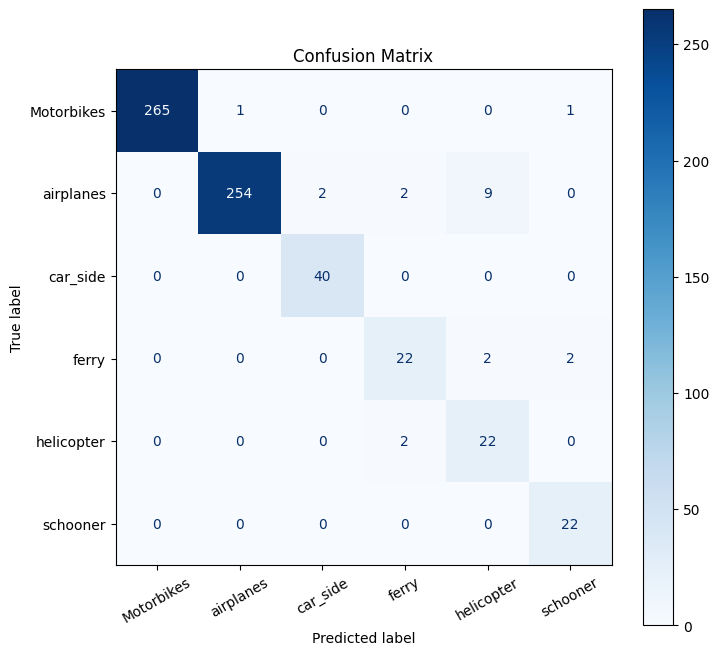

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='Blues', xticks_rotation=30)
plt.title("Confusion Matrix")
plt.show()

#### Learning curves

Plot learning curves to spot signs of overfitting and underfitting, and to see when training and validation get stable.

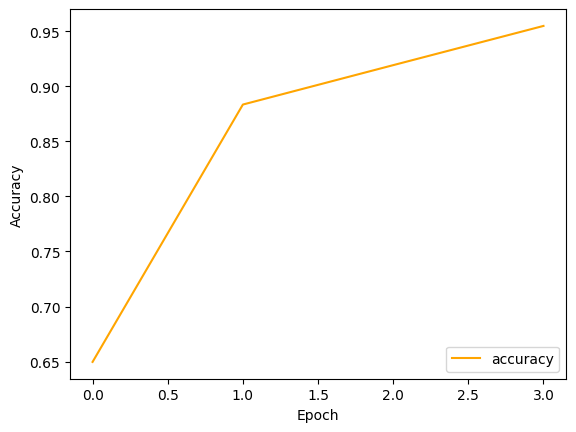

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

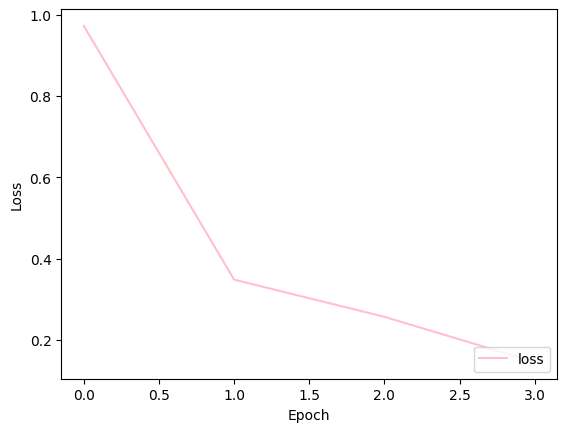

In [ ]:
plt.plot(history.history['loss'], label='loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#### ROC curve

Plot ROC curve for each class to evaluate the model's performance for each class.

shape: (646, 6)
2d sample: [1 0 0 0 0 0]


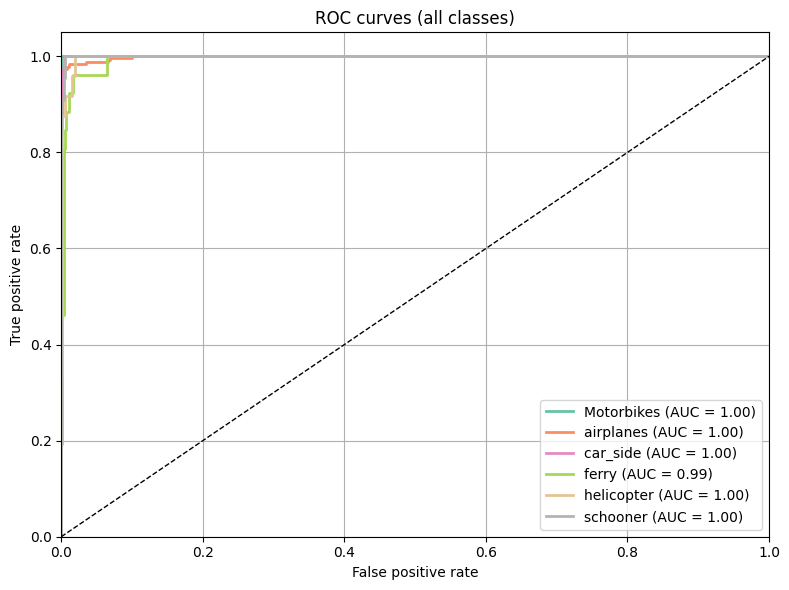

In [ ]:
# arrays from lists
y_test = np.array(true_labels)        # 1D true labels
y_score = np.array(predictions_full)  # 2D (n_samples, n_classes)

n_classes = y_score.shape[1]          # amount of classes
classes = list(range(n_classes))      # list with class indices [0-5]

# make y_test a 2d arr
# so ROC can be calculated for each class separately
y_test_bin = label_binarize(y_test, classes=classes) # shape: (n_samples, n_classes)
print('shape:', y_test_bin.shape)
print('2d sample:', y_test_bin[0])

# ROC curve
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("Set2", n_classes)

for i in range(n_classes):
  fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i]) # fpr = false pos rate, tpr = true pos rate
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1) # dashed line = chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (all classes)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

#### PRC

Create a precision recall curve for each class to observe how the model performs on them and spot imbalances. Focus is on the quality of positive-predictions.

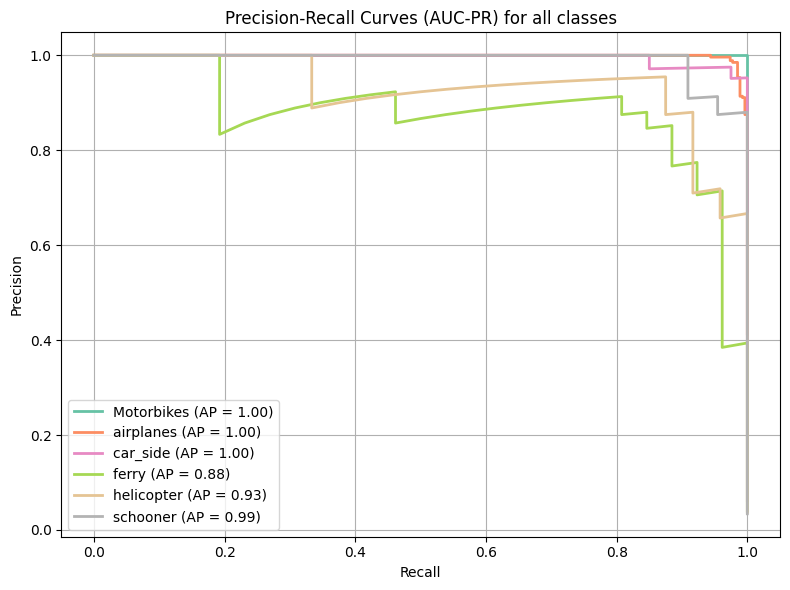

In [ ]:
# arrays from lists
y_test = np.array(true_labels)        # shape: (n_samples, )
y_score = np.array(predictions_full)  # shape: (n_samples, n_classes)

# get no of classes
n_classes = y_score.shape[1]          # [6]
classes = list(range(n_classes))      # [0, ..., 5]

# binarization (one-vs-rest) --> to calc precision and recall for each class separately
y_test_bin = label_binarize(y_test, classes=classes)  # shape: (n_samples, n_classes)

# plot
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("Set2", n_classes)

for i in range(n_classes):
  precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])  # (y_true, y_score)
  ap_score = average_precision_score(y_test_bin[:, i], y_score[:, i])

  plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {ap_score:.2f})', color=colors(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (AUC-PR) for all classes')
plt.legend(loc='best')  # place legend in best suited place
plt.grid()
plt.tight_layout()
plt.show()

This vanilla CNN already performs very well. Even the category it performs worst on and misses some positive-predictions, the `ferry` category, is predicted rather reliably. In the next step, we will see whether this performance can be exceeded by the use of a frozen pre-trained ResNet50.

## Frozen pre-trained ResNet

In [19]:
def preprocess_batch(image, label):
  # normalize my images to make them compatible with the pretrained resnet
  image = tf.keras.applications.resnet.preprocess_input(image)
  return image, label

ds_train = ds_train.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

input_shape = (min_height, min_width, 3)
num_classes = len(class_names)

# load resnet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base.trainable = False

# build model
resnet_frozen = tf.keras.models.Sequential([
    resnet_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# compile model
resnet_frozen.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_frozen.summary()

# training
resnet_frozen_test = ds_test.map(preprocess_batch)
resnet_frozen_val = ds_val.map(preprocess_batch)

resnet_frozen_history = resnet_frozen.fit(
    ds_train,
    epochs = 4,
    validation_data = ds_val
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 6, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/4
     84/Unknown 244s 3s/step - accuracy: 0.8950 - loss: 0.4040

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


84/84 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8959 - loss: 0.4009 - val_accuracy: 0.9948 - val_loss: 0.0170
Epoch 2/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9982 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9961 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0018


### Evaluation

In [20]:
train_acc = resnet_frozen_history.history['accuracy']
val_acc = resnet_frozen_history.history['val_accuracy']

mean_train_acc = np.mean(train_acc)
mean_val_acc = np.mean(val_acc)

print(f"Ø train accuracy: {mean_train_acc*100:.2f} %")
print(f"Ø validation accuracy: {mean_val_acc*100:.2f} %")

Ø train accuracy: 99.01 %
Ø validation accuracy: 99.87 %


#### Classification report

In [21]:
resnet_frozen_true = []
resnet_frozen_pred = []
resnet_frozen_pred_proba = []
resnet_frozen_pred_full = []

for images, labels in resnet_frozen_test:
  predictions = resnet_frozen.predict(images)             # predictions for images in test ds
  predicted_classes = np.argmax(predictions, axis=1)      # top 1 prediction
  predicted_probabilities = np.max(predictions, axis=1)   # highest probability value (how sure the model is of its prediction)

  resnet_frozen_true.extend(labels.numpy())
  resnet_frozen_pred.extend(predicted_classes)
  resnet_frozen_pred_proba.extend(predicted_probabilities)
  resnet_frozen_pred_full.extend(predictions)

# classification report
report = classification_report(resnet_frozen_true, resnet_frozen_pred)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       264
           1       1.00      0.86      0.92       265
           2       0.98      1.00      0.99        41
           3       0.66    

#### Top 1 error rate (%)

In [22]:
# arrays from lists
y_test = np.array(resnet_frozen_true)        # shape: (n_samples, )
y_score = np.array(resnet_frozen_pred_full)  # shape: (n_samples, n_classes)

# get highest probability for each test example
y_pred = np.argmax(y_score, axis=1)

# calculate accuracy
acc = accuracy_score(y_test, y_pred)

# Share of false predictions
top1_error = (1 - acc) * 100

print(f"Top-1 error rate: {top1_error:.2f}%")

Top-1 error rate: 6.19%


#### Confusion Matrix

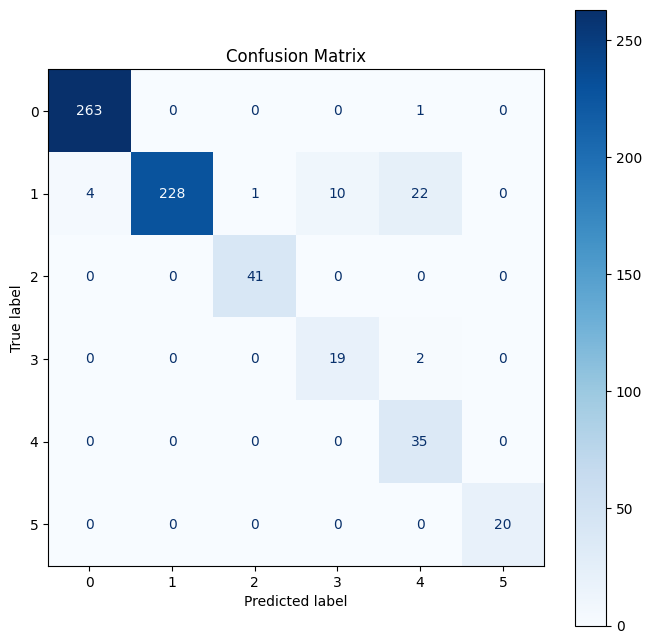

In [23]:
cm = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(resnet_frozen_true, resnet_frozen_pred)
    )
fig, ax = plt.subplots(figsize=(8, 8))
cm.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 0 = Motorbikes, 1 = airplanes, 2 = car_side, 3 = ferry, 4 = helicopter, 5 = schooner

#### Learning curves

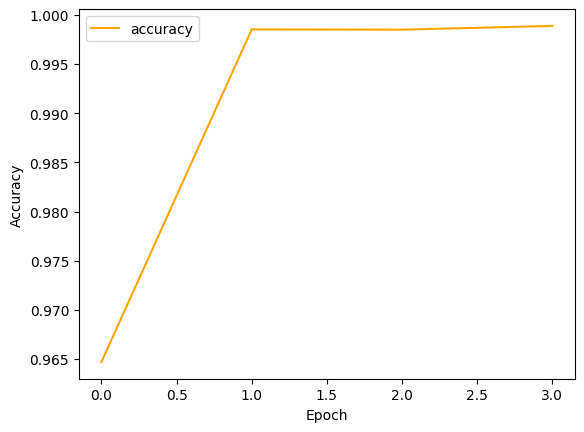

In [24]:
plt.plot(resnet_frozen_history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

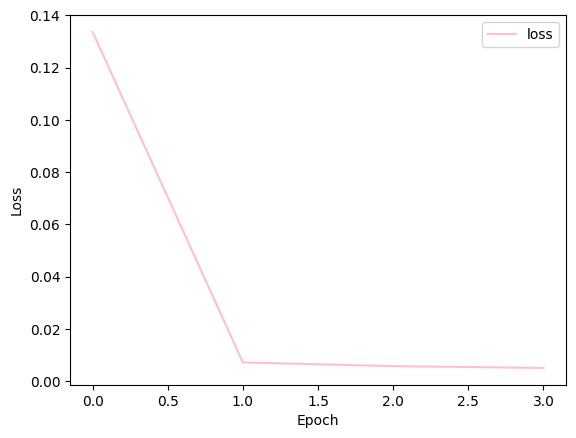

In [26]:
plt.plot(resnet_frozen_history.history['loss'], label='loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

#### ROC curve

Plot ROC curve for each class to evaluate the model's performance for each class.

shape: (646, 6)
2d sample: [1 0 0 0 0 0]


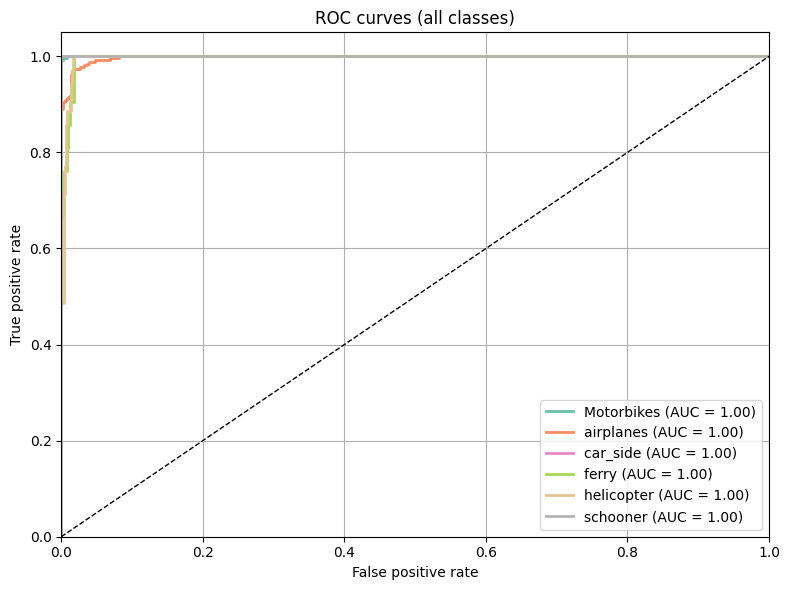

In [25]:
# arrays from lists
y_test = np.array(resnet_frozen_true)        # 1D true labels
y_score = np.array(resnet_frozen_pred_full)  # 2D (n_samples, n_classes)

n_classes = y_score.shape[1]          # amount of classes
classes = list(range(n_classes))      # list with class indices [0-5]

# make y_test a 2d arr
# so ROC can be calculated for each class separately
y_test_bin = label_binarize(y_test, classes=classes) # shape: (n_samples, n_classes)
print('shape:', y_test_bin.shape)
print('2d sample:', y_test_bin[0])

# ROC curve
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("Set2", n_classes)

for i in range(n_classes):
  fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i]) # fpr = false pos rate, tpr = true pos rate
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1) # dashed line = chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (all classes)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

#### PRC

Create a precision recall curve for each class to observe how the model performs on them and spot imbalances. Focus is on the quality of positive-predictions.

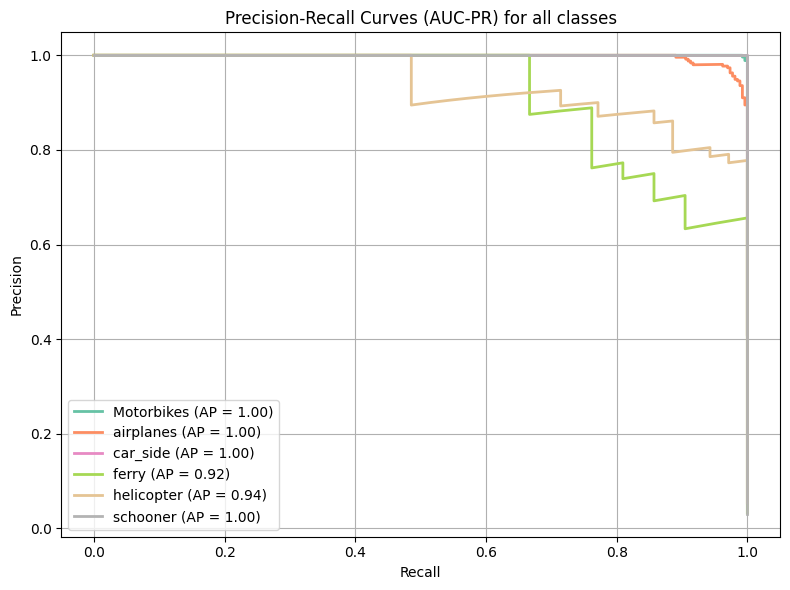

In [27]:
# arrays from lists
y_test = np.array(resnet_frozen_true)        # shape: (n_samples, )
y_score = np.array(resnet_frozen_pred_full)  # shape: (n_samples, n_classes)

# get no of classes
n_classes = y_score.shape[1]          # [6]
classes = list(range(n_classes))      # [0, ..., 5]

# binarization (one-vs-rest) --> to calc precision and recall for each class separately
y_test_bin = label_binarize(y_test, classes=classes)  # shape: (n_samples, n_classes)

# plot
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("Set2", n_classes)

for i in range(n_classes):
  precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])  # (y_true, y_score)
  ap_score = average_precision_score(y_test_bin[:, i], y_score[:, i])

  plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {ap_score:.2f})', color=colors(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (AUC-PR) for all classes')
plt.legend(loc='best')  # place legend in best suited place
plt.grid()
plt.tight_layout()
plt.show()

Using ResNet50 did bring further improvements. Notably, the `ferry` category is predicted much better now. Interestingly, the model seems to mis-predict some `helicopter` images now.

## Fine-tuned pre-trained ResNet

I am again using the ResNet50 model, this time unfreezing some of the layers.

In [ ]:
def preprocess_batch(image, label):
  # normalize my images to make them compatible with the pretrained resnet
  image = tf.keras.applications.resnet.preprocess_input(image)
  return image, label

input_shape = (min_height, min_width, 3)
num_classes = len(class_names)

# load resnet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base.trainable = False

# build model
resnet_frozen = tf.keras.models.Sequential([
    resnet_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# compile model
resnet_frozen.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# unfreeze entire model
resnet_base.trainable = True

# train last 30 layers
for layer in resnet_base.layers[:-30]:
  layer.trainable = False

# compile
resnet_frozen.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train
resnet_frozen_test = ds_test.map(preprocess_batch)
resnet_frozen_val = ds_val.map(preprocess_batch)

early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

resnet_frozen_history = resnet_frozen.fit(
    ds_train,
    epochs = 4,
    validation_data = ds_val,
    callbacks=[early_stop]
)

Epoch 1/4
     84/Unknown 372s 4s/step - accuracy: 0.5263 - loss: 1.3067

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


84/84 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.5277 - loss: 1.3040 - val_accuracy: 0.9326 - val_loss: 0.2449
Epoch 2/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.8772 - loss: 0.5016 - val_accuracy: 0.9845 - val_loss: 0.0927
Epoch 3/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - accuracy: 0.9344 - loss: 0.2549 - val_accuracy: 0.9948 - val_loss: 0.0515
Epoch 4/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.9725 - loss: 0.1401 - val_accuracy: 0.9896 - val_loss: 0.0494


### Evaluation

In [ ]:
train_acc = resnet_frozen_history.history['accuracy']
val_acc = resnet_frozen_history.history['val_accuracy']

mean_train_acc = np.mean(train_acc)
mean_val_acc = np.mean(val_acc)

print(f"Ø train accuracy: {mean_train_acc*100:.2f} %")
print(f"Ø validation accuracy: {mean_val_acc*100:.2f} %")

Ø train accuracy: 88.22 %
Ø validation accuracy: 97.54 %


#### Classification report

In [ ]:
resnet_frozen_true = []
resnet_frozen_pred = []
resnet_frozen_pred_proba = []
resnet_frozen_pred_full = []

for images, labels in resnet_frozen_test:
  predictions = resnet_frozen.predict(images)               # predictions for images in test ds
  predicted_classes = np.argmax(predictions, axis=1)        # top 1 prediction
  predicted_probabilities = np.max(predictions, axis=1)     # highest probability value (how sure the model is of its prediction)

  resnet_frozen_true.extend(labels.numpy())
  resnet_frozen_pred.extend(predicted_classes)
  resnet_frozen_pred_proba.extend(predicted_probabilities)
  resnet_frozen_pred_full.extend(predictions)

# classification report
report = classification_report(resnet_frozen_true, resnet_frozen_pred)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       277
           1       1.00      0.95      0.97       266
           2       1.00      0.98      0.99        43
           3       1.00    

#### Top 1 error rate (%)

In [ ]:
# arrays from lists
y_test = np.array(resnet_frozen_true)        # shape: (n_samples, )
y_score = np.array(resnet_frozen_pred_full)  # shape: (n_samples, n_classes)

# get highest probability for each test example
y_pred = np.argmax(y_score, axis=1)

# calculate accuracy
acc = accuracy_score(y_test, y_pred)

# Share of false predictions
top1_error = (1 - acc) * 100

print(f"Top-1 error rate: {top1_error:.2f}%")

Top-1 error rate: 2.48%


#### Confusion Matrix

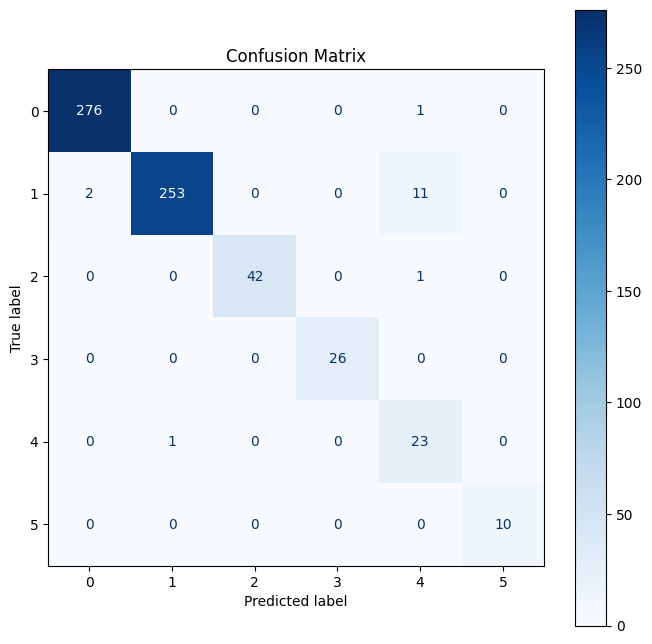

In [ ]:
cm = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(resnet_frozen_true, resnet_frozen_pred)
    )
fig, ax = plt.subplots(figsize=(8, 8))
cm.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 0 = Motorbikes, 1 = airplanes, 2 = car_side, 3 = ferry, 4 = helicopter, 5 = schooner

#### Learning curves

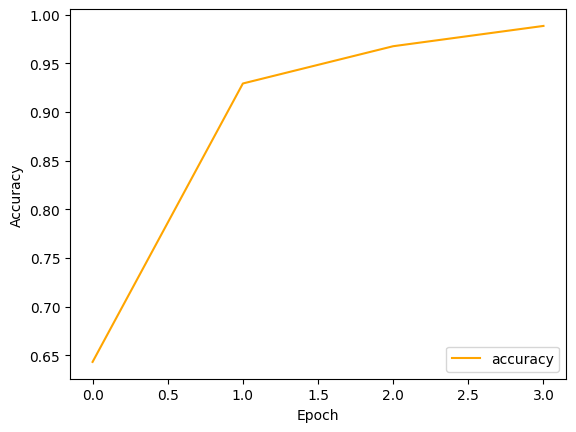

In [ ]:
plt.plot(resnet_frozen_history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

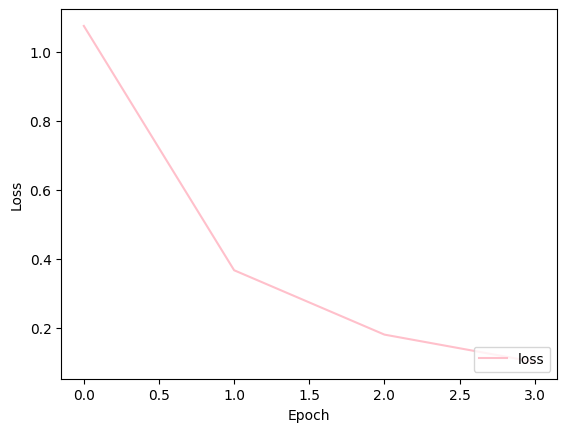

In [ ]:
plt.plot(resnet_frozen_history.history['loss'], label='loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#### ROC curve

Plot ROC curve for each class to evaluate the model's performance for each class.

shape: (646, 6)
2d sample: [0 1 0 0 0 0]


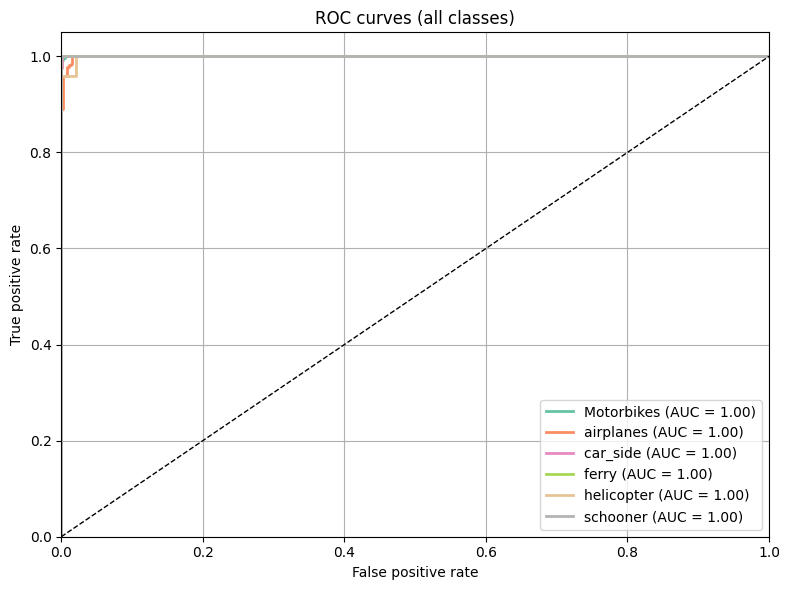

In [ ]:
# arrays from lists
y_test = np.array(resnet_frozen_true)        # 1D true labels
y_score = np.array(resnet_frozen_pred_full)  # 2D (n_samples, n_classes)

n_classes = y_score.shape[1]          # amount of classes
classes = list(range(n_classes))      # list with class indices [0-5]

# make y_test a 2d arr
# so ROC can be calculated for each class separately
y_test_bin = label_binarize(y_test, classes=classes) # shape: (n_samples, n_classes)
print('shape:', y_test_bin.shape)
print('2d sample:', y_test_bin[0])

# ROC curve
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("Set2", n_classes)

for i in range(n_classes):
  fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i]) # fpr = false pos rate, tpr = true pos rate
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1) # dashed line = chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (all classes)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

#### PRC

Create a precision recall curve for each class to observe how the model performs on them and spot imbalances. Focus is on the quality of positive-predictions.

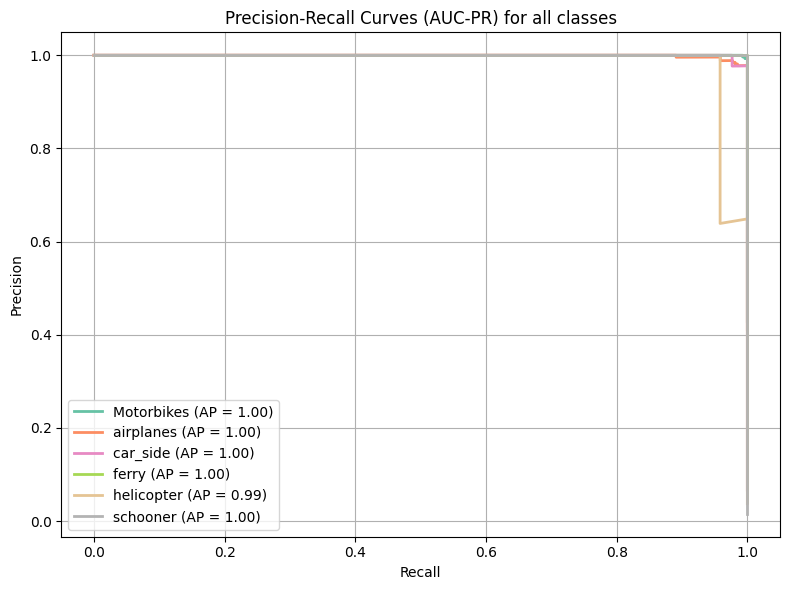

In [ ]:
# arrays from lists
y_test = np.array(resnet_frozen_true)        # shape: (n_samples, )
y_score = np.array(resnet_frozen_pred_full)  # shape: (n_samples, n_classes)

# get no of classes
n_classes = y_score.shape[1]          # [6]
classes = list(range(n_classes))      # [0, ..., 5]

# binarization (one-vs-rest) --> to calc precision and recall for each class separately
y_test_bin = label_binarize(y_test, classes=classes)  # shape: (n_samples, n_classes)

# plot
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("Set2", n_classes)

for i in range(n_classes):
  precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])  # (y_true, y_score)
  ap_score = average_precision_score(y_test_bin[:, i], y_score[:, i])

  plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {ap_score:.2f})', color=colors(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (AUC-PR) for all classes')
plt.legend(loc='best')  # place legend in best suited place
plt.grid()
plt.tight_layout()
plt.show()



---

# Conclusion


The most efficient approach is using the frozen ResNet50. It took a short amount of time to train than the ResNet50 with unfrozen layers. The latter performed worse, especially when correctly predicting helicopters and airplanes. The frozen ResNet50 was able to improve on the metrics of the Vanilla CNN, like the `helicopter` classes precision. I was pleasantly surprised by the Vanilla CNNs performance, though.